In [1]:
import glob
import numpy as np

output_folder = 'output/output/z'
npzfiles = glob.glob(output_folder + "/*.npz") # saved npz files
thresholds = {f : np.float(f.split('/')[-1][9:-4]) for f in npzfiles}
z = {thresholds[npzfile]:np.load(npzfile) for npzfile in npzfiles} # list of saved Weights
keys = z.values()[0].files# name of layers in Weights
keys.sort()

In [2]:
# compute number of non-zeros in each layer across thresholds
nnz = []
rnz = [] # ratio of nnz / total
sort_thresh = np.sort(thresholds.values())
for key in keys:
    nnz.append([np.sum(z[s][key] != 0) + 1 for s in sort_thresh]) # add 1 for logplot later
    rnz.append([np.sum(z[s][key] != 0) * 1.0 / z[s][key].size + 1e-10 for s in sort_thresh])
print('number of network layers selected: {:d}'.format(len(nnz)) )

number of network layers selected: 22


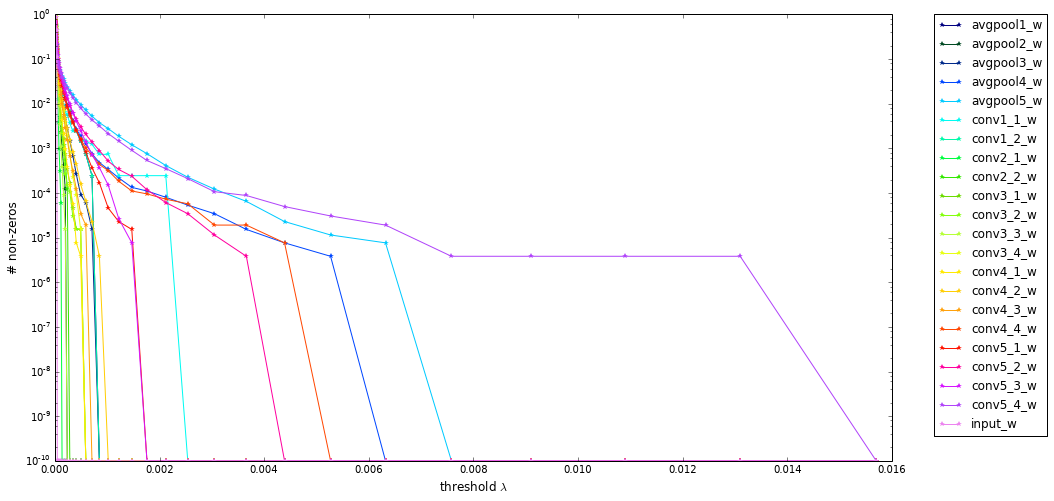

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
num_plots = len(keys)
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

init = 0#-10
for line, key in zip(rnz, keys):#zip(nnz, keys):
    plt.semilogy(sort_thresh[init:], line[init:], label=key, marker='*',markeredgewidth=0.0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("# non-zeros", fontsize=12)
plt.xlabel(r'threshold $ \lambda$', fontsize=12)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

### Weights_individual: count number of selections of each filter

In [5]:
from collections import Counter
def find_nonzero(w):
    locs = zip(*np.nonzero(w))
    filters = Counter([x[-1] for x in locs])
#     values = [w[loc] for loc in locs]
    return (locs, filters)

cut = z[sort_thresh[-16]]
weights = {}
for key in keys:
    _, filters = find_nonzero(cut[key])
    if len(filters) > 0:
        print("{:d} filters in layer {:s}".format(len(filters), key))
#         style_filters[key[:-2]] = filters
        weights[key[:-2]] = np.mean(np.abs(cut[key]), axis =(0,1))
C = [np.mean(weight) for _, weight in weights.iteritems() ]
C = np.amax(C)
for key, value in weights.iteritems():
    weights[key] = value / C

5 filters in layer avgpool1_w
29 filters in layer avgpool2_w
48 filters in layer avgpool3_w
282 filters in layer avgpool4_w
222 filters in layer avgpool5_w
12 filters in layer conv1_1_w
5 filters in layer conv1_2_w
16 filters in layer conv2_1_w
44 filters in layer conv2_2_w
80 filters in layer conv3_1_w
56 filters in layer conv3_2_w
29 filters in layer conv3_3_w
64 filters in layer conv3_4_w
182 filters in layer conv4_1_w
283 filters in layer conv4_2_w
370 filters in layer conv4_3_w
405 filters in layer conv4_4_w
284 filters in layer conv5_1_w
328 filters in layer conv5_2_w
327 filters in layer conv5_3_w
287 filters in layer conv5_4_w


In [6]:
# write output
import pickle
with open("test.pkl", 'wb') as f:
    pickle.dump(weights, f)

### Weights_covariance

In [12]:
thresh = sort_thresh[-24]
cut = z[thresh]
weights = {}
print('at threshold: {:.4e}'.format(thresh))
for key in keys:
    if np.count_nonzero(cut[key]):
        weights[key[:-2]] = cut[key]
        print('{} nonzero in covariance at {}'.format( np.count_nonzero(cut[key]), key ) )
        print('mean: {:.4e}'.format( np.mean(cut[key][np.nonzero(cut[key])]) ))
C = [np.mean(weight) for _, weight in weights.iteritems() ]
C = np.amax(C)
for key, value in weights.iteritems():
    weights[key] = value / C

at threshold: 2.3700e-04
38 nonzero in covariance at avgpool1_w
mean: 2.1041e-05
187 nonzero in covariance at avgpool3_w
mean: 1.2036e-05
2216 nonzero in covariance at avgpool4_w
mean: 2.6827e-05
6248 nonzero in covariance at avgpool5_w
mean: 3.9690e-05
23 nonzero in covariance at conv1_1_w
mean: 4.8706e-05
36 nonzero in covariance at conv1_2_w
mean: 2.3408e-05
2 nonzero in covariance at conv2_2_w
mean: 3.4596e-06
22 nonzero in covariance at conv3_1_w
mean: 1.1279e-05
10 nonzero in covariance at conv3_2_w
mean: 1.2742e-05
125 nonzero in covariance at conv3_4_w
mean: 9.2365e-06
102 nonzero in covariance at conv4_1_w
mean: 8.4074e-06
766 nonzero in covariance at conv4_2_w
mean: 1.3713e-05
411 nonzero in covariance at conv4_3_w
mean: 1.0538e-05
2076 nonzero in covariance at conv4_4_w
mean: 2.4651e-05
2356 nonzero in covariance at conv5_1_w
mean: 2.2168e-05
3344 nonzero in covariance at conv5_2_w
mean: 3.1720e-05
3858 nonzero in covariance at conv5_3_w
mean: 2.0270e-05
5757 nonzero in cova

In [13]:
# write output
import pickle
with open("test.pkl", 'wb') as f:
    pickle.dump(weights, f)

--------

In [14]:
# read input
with open("test.pkl", 'r') as f:
    test = pickle.load(f)

In [27]:
# check variable selection path

locs,values = find_nonzero(z[sort_thresh[-5]]['conv5_2_w'])
for key in keys:
    print("checking {}".format(key))
    locs_old,_ = find_nonzero(z[sort_thresh[9]][key])
    locs_old = set([x[2] for x in locs_old])
    for s in sort_thresh[10:]:
        locs,_ = find_nonzero(z[s][key])
        locs = set(x[2] for x in locs)
        if len(locs) > 0:
            if any([loc not in locs_old for loc in locs]):
                print("Variable selection in {} not inclustive at threshold: {:4e}".format(key, s))
            locs_old = locs
#             print("{:.2f}% are non-zeros at threshold {:.2e}".format(len(locs)*100.0/z[s][key].shape[-1], s))

checking avgpool1_w
checking avgpool2_w
checking avgpool3_w
checking avgpool4_w
checking avgpool5_w
checking conv1_1_w
checking conv1_2_w
checking conv2_1_w
checking conv2_2_w
checking conv3_1_w
checking conv3_2_w
checking conv3_3_w
checking conv3_4_w
checking conv4_1_w
checking conv4_2_w
checking conv4_3_w
checking conv4_4_w
checking conv5_1_w
checking conv5_2_w
checking conv5_3_w
checking conv5_4_w
checking input_w


In [33]:
for key in test.keys():
    print key,test[key]

conv5_4 Counter({117: 22, 296: 20, 397: 14, 183: 14, 307: 13, 198: 12, 230: 12, 217: 11, 7: 7, 141: 7, 44: 7, 280: 6, 412: 6, 92: 6, 54: 5, 201: 3, 396: 3, 468: 3, 196: 2, 55: 2, 301: 2, 17: 1, 276: 1, 343: 1, 25: 1, 176: 1})
conv5_1 Counter({38: 4, 58: 2, 135: 2, 505: 1, 446: 1})
conv5_3 Counter({492: 6, 112: 2, 433: 2, 453: 2, 199: 2, 376: 2, 11: 1})
conv5_2 Counter({3: 9, 126: 6, 23: 3, 110: 3, 115: 3, 180: 2, 87: 2, 377: 2, 506: 1, 187: 1})
conv4_4 Counter({289: 94, 488: 77, 382: 55, 132: 33, 27: 32, 402: 9, 249: 7, 332: 6, 161: 5, 175: 5, 55: 5, 250: 5, 192: 4, 451: 3, 439: 3, 251: 3, 49: 3, 128: 2, 136: 2, 362: 2, 491: 2, 51: 2, 129: 1, 452: 1, 32: 1, 243: 1, 496: 1, 443: 1, 383: 1})
conv4_2 Counter({336: 1})
avgpool4 Counter({289: 21, 488: 18, 382: 11, 132: 9, 27: 7, 332: 2, 402: 2, 249: 2, 161: 1, 55: 1})
avgpool5 Counter({117: 6, 296: 5, 397: 4, 183: 4, 230: 3, 198: 2, 92: 2, 44: 2, 307: 2, 217: 2, 7: 1, 141: 1, 54: 1, 280: 1, 412: 1})


In [50]:
import tensorflow as tf
N = tf.size(test['avgpool2'].keys())
t1 = tf.constant(test['avgpool2'].keys(), dtype=tf.int64, shape =[12,1])
t2 = tf.constant(test['avgpool2'].values(), dtype=tf.int64, shape=[12])
t3 = tf.constant(z[1e-06]['avgpool2_w'].size, dtype=tf.int64, shape=[1])
tf.SparseTensor(t1, t2, t3)

In [58]:
tmp = test['avgpool2'].keys()
tmp.sort()
tmp

[6, 11, 23, 30, 45, 63, 77, 78, 82, 86, 102, 115]

In [15]:
for key in test.keys():
    print('{} mean: {:.4e}'.format(key, np.mean(test[key]) ) )

conv5_4 mean: 8.1146e-01
avgpool5 mean: 1.0000e+00
conv5_1 mean: 2.1061e-01
conv5_3 mean: 3.1536e-01
conv5_2 mean: 4.2774e-01
conv4_4 mean: 2.0637e-01
conv4_1 mean: 3.4581e-03
conv4_2 mean: 4.2358e-02
conv4_3 mean: 1.7466e-02
conv3_4 mean: 1.8623e-02
conv3_2 mean: 2.0552e-03
conv3_1 mean: 4.0025e-03
conv1_1 mean: 2.8911e-01
avgpool4 mean: 2.3973e-01
conv1_2 mean: 2.1748e-01
conv2_2 mean: 4.4643e-04
avgpool3 mean: 3.6304e-02
avgpool1 mean: 2.0636e-01
